In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("KafkaGraphFramesAnalysis") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.jars.packages", 
            "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3,"
            "org.apache.kafka:kafka-clients:3.5.0,"
            "graphframes:graphframes:0.8.2-spark3.0-s_2.12") \
    .getOrCreate()
spark.sparkContext.setCheckpointDir("file:///tmp/graphframes_checkpoint")
print("Checkpoint directory set successfully!")


Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true
Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true
25/01/02 06:28:29 WARN Utils: Your hostname, kali resolves to a loopback address: 127.0.1.1; using 192.168.72.129 instead (on interface eth0)
25/01/02 06:28:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/kali/venvs/jupyter-env/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/kali/.ivy2/cache
The jars for the packages stored in: /home/kali/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
org.apache.kafka#kafka-clients added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e42ac4ff-b93f-4385-9580-568ce14d51b7;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.3 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.3 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
	found org.apache.kafka#kafka-clients;3.5.0 in central
	found c

Checkpoint directory set successfully!


In [2]:
from graphframes import GraphFrame


In [3]:
df_streaming = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "digitransit_data") \
    .load()

df_streaming = df_streaming.selectExpr("CAST(value AS STRING)")
df_streaming.printSchema()

root
 |-- value: string (nullable = true)



In [4]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, from_json, from_unixtime, decode
from pyspark.sql.types import StructType, StructField, ArrayType, StringType, DoubleType, LongType, IntegerType

# Define the schema for the JSON data
schema = StructType([
    StructField("data", StructType([
        StructField("plan", StructType([
            StructField("itineraries", ArrayType(StructType([
                StructField("walkDistance", DoubleType()),
                StructField("duration", IntegerType()),
                StructField("legs", ArrayType(StructType([
                    StructField("mode", StringType()),
                    StructField("startTime", LongType()),
                    StructField("endTime", LongType()),
                    StructField("from", StructType([
                        StructField("lat", DoubleType()),
                        StructField("lon", DoubleType()),
                        StructField("name", StringType()),
                        StructField("stop", StructType([
                            StructField("patterns", ArrayType(StructType([
                                StructField("code", StringType(), True)                          
                            ])))
                        ]))
                    ])),
                    StructField("to", StructType([
                        StructField("lat", DoubleType()),
                        StructField("lon", DoubleType()),
                        StructField("name", StringType()),
                        StructField("stop", StructType([
                            StructField("patterns", ArrayType(StructType([
                                StructField("code", StringType(), True)                       
                            ])))
                        ]))
                    ])),
                    StructField("trip", StructType([
                        StructField("gtfsId", StringType()),
                        StructField("pattern", StructType([
                            StructField("trip_pattern_code", StringType(), True)                        
                        ])),
                                StructField("tripHeadsign", StringType())
                    ]))
                ])))
            ])))
        ]))
    ]))
])

df_parsed = df_streaming.select(
    from_json(decode(col("value"), "UTF-8"), schema).alias("data")
)
df_parsed.printSchema()

root
 |-- data: struct (nullable = true)
 |    |-- data: struct (nullable = true)
 |    |    |-- plan: struct (nullable = true)
 |    |    |    |-- itineraries: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- walkDistance: double (nullable = true)
 |    |    |    |    |    |-- duration: integer (nullable = true)
 |    |    |    |    |    |-- legs: array (nullable = true)
 |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |-- mode: string (nullable = true)
 |    |    |    |    |    |    |    |-- startTime: long (nullable = true)
 |    |    |    |    |    |    |    |-- endTime: long (nullable = true)
 |    |    |    |    |    |    |    |-- from: struct (nullable = true)
 |    |    |    |    |    |    |    |    |-- lat: double (nullable = true)
 |    |    |    |    |    |    |    |    |-- lon: double (nullable = true)
 |    |    |    |    |    |    |    |    |-- n

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, col, date_format

# Flatten the nested "legs" array 
df_legs = df_parsed.select(
    F.explode(col("data.data.plan.itineraries.legs")).alias("leg")
)

#Create Vertices 
df_vertices = df_legs.select(
    explode(col("leg.from.name")).alias("id")  
).union(
    df_legs.select(explode(col("leg.to.name")).alias("id"))  
).distinct()


# Create Edges 
df_edges = df_legs.select(
    explode(col("leg.from.name")).alias("src"),               
    explode(col("leg.to.name")).alias("dst"),                 
    explode(col("leg.trip.gtfsId")).alias("trip_id"),         
    explode(col("leg.mode")).alias("mode"),                   
)

df_edges.printSchema()


root
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- trip_id: string (nullable = true)
 |-- mode: string (nullable = true)



In [6]:
# Write vertices and edges to memory
vertices_query = df_vertices.writeStream \
    .format("memory") \
    .queryName("vertices_stream") \
    .outputMode("append") \
    .start()
edges_query = df_edges.writeStream \
    .format("memory") \
    .queryName("edges_stream") \
    .outputMode("append") \
    .start()



25/01/02 06:28:35 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-d0ddd0a1-1bc3-42f5-8929-b05e6394279a. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/01/02 06:28:35 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/01/02 06:28:35 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-c01d2c1d-9df7-4ed2-9790-63c3eccd9fd4. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/01/02 06:28:35 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not support

In [13]:
# Read vertices snapshot as a static DataFrame
static_vertices = spark.sql("SELECT * FROM vertices_stream")

# Read edges snapshot as a static DataFrame
static_edges = spark.sql("SELECT * FROM edges_stream")

# Display snapshots
static_vertices.show()
static_edges.show(40)


+------------------+
|                id|
+------------------+
|       Destination|
|            Origin|
|         Tupasaari|
|Asemapäällikönkatu|
|     Pasilan asema|
+------------------+

+------------------+------------------+--------------------+----+
|               src|               dst|             trip_id|mode|
+------------------+------------------+--------------------+----+
|            Origin|Asemapäällikönkatu|                NULL|WALK|
|            Origin|Asemapäällikönkatu|                NULL| BUS|
|            Origin|Asemapäällikönkatu|                NULL|WALK|
|            Origin|Asemapäällikönkatu|HSL:1059_20250101...|WALK|
|            Origin|Asemapäällikönkatu|HSL:1059_20250101...| BUS|
|            Origin|Asemapäällikönkatu|HSL:1059_20250101...|WALK|
|            Origin|Asemapäällikönkatu|                NULL|WALK|
|            Origin|Asemapäällikönkatu|                NULL| BUS|
|            Origin|Asemapäällikönkatu|                NULL|WALK|
|            Origi

In [14]:
from graphframes import GraphFrame

g = GraphFrame(static_vertices, static_edges)

/home/kali/venvs/jupyter-env/lib/python3.12/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [15]:
g.vertices.show()
g.edges.show()



+------------------+
|                id|
+------------------+
|       Destination|
|            Origin|
|         Tupasaari|
|Asemapäällikönkatu|
|     Pasilan asema|
+------------------+

+------+------------------+--------------------+----+
|   src|               dst|             trip_id|mode|
+------+------------------+--------------------+----+
|Origin|Asemapäällikönkatu|                NULL|WALK|
|Origin|Asemapäällikönkatu|                NULL| BUS|
|Origin|Asemapäällikönkatu|                NULL|WALK|
|Origin|Asemapäällikönkatu|HSL:1059_20250101...|WALK|
|Origin|Asemapäällikönkatu|HSL:1059_20250101...| BUS|
|Origin|Asemapäällikönkatu|HSL:1059_20250101...|WALK|
|Origin|Asemapäällikönkatu|                NULL|WALK|
|Origin|Asemapäällikönkatu|                NULL| BUS|
|Origin|Asemapäällikönkatu|                NULL|WALK|
|Origin|         Tupasaari|                NULL|WALK|
|Origin|         Tupasaari|                NULL| BUS|
|Origin|         Tupasaari|                NULL|WALK|


In [16]:
in_degree = g.inDegrees
in_degree.show()

out_degree = g.outDegrees
out_degree.show()


+------------------+--------+
|                id|inDegree|
+------------------+--------+
|       Destination|     729|
|         Tupasaari|     729|
|Asemapäällikönkatu|     513|
|     Pasilan asema|     216|
+------------------+--------+

+------------------+---------+
|                id|outDegree|
+------------------+---------+
|            Origin|      729|
|         Tupasaari|      729|
|Asemapäällikönkatu|      513|
|     Pasilan asema|      216|
+------------------+---------+



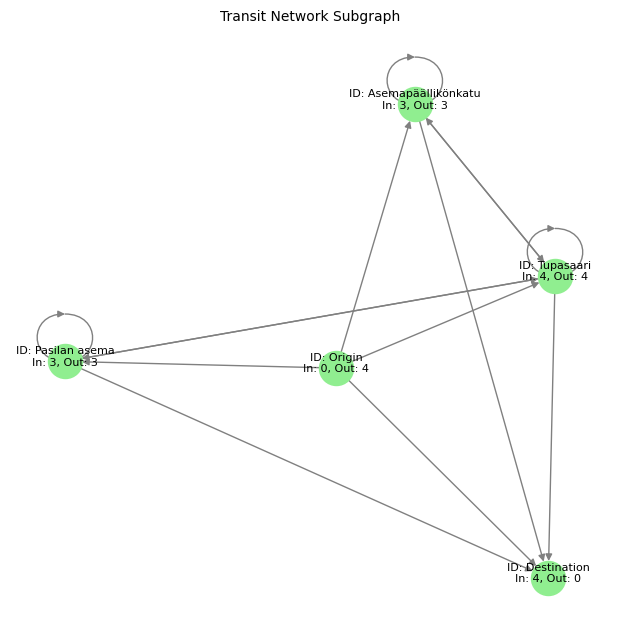

In [46]:
from pyspark.sql import functions as F
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

# Convert the vertices (stops) and edges (routes) DataFrames to Pandas
vertices_df = g.vertices.toPandas()
edges_df = g.edges.toPandas()

# Create a directed graph
G = nx.DiGraph()

# Add nodes (vertices) to the NetworkX graph
for index, row in vertices_df.iterrows():
    node_id = row['id']
    G.add_node(node_id)  

# Add edges to the NetworkX graph
for index, row in edges_df.iterrows():
    src = row['src']
    dst = row['dst']
    G.add_edge(src, dst)  

# Compute in-degrees and out-degrees for each node
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Assign in-degrees and out-degrees as node attributes
for node in G.nodes:
    G.nodes[node]['in_degree'] = in_degrees.get(node, 0)
    G.nodes[node]['out_degree'] = out_degrees.get(node, 0)

# Limit the number of nodes and edges to display
max_nodes = 15  
max_edges = 20  

# Randomly sample a subset of nodes and edges
sampled_nodes = random.sample(list(G.nodes), min(max_nodes, len(G.nodes)))
sampled_edges = random.sample(list(G.edges), min(max_edges, len(G.edges)))

# Create a subgraph with sampled nodes and edges
subgraph = G.subgraph(sampled_nodes).copy()
subgraph.add_edges_from([edge for edge in sampled_edges if edge[0] in subgraph.nodes and edge[1] in subgraph.nodes])

# Generate positions using a spring layout
pos = nx.spring_layout(subgraph)

# Plot the subgraph 
plt.figure(figsize=(6, 6))  
nx.draw(
    subgraph,
    pos,
    with_labels=False,  
    node_size=600,
    node_color='lightgreen',
    edge_color='gray',
    width=1
)

node_labels = {
    node: f"ID: {node}\nIn: {subgraph.nodes[node]['in_degree']}, Out: {subgraph.nodes[node]['out_degree']}"
    for node in subgraph.nodes
}

offset_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
nx.draw_networkx_labels(subgraph, pos=offset_pos, labels=node_labels, font_size=8)

plt.title("Transit Network Subgraph", fontsize=10)
plt.show()


In [18]:
# Find specific motifs in the graph
motifs = g.find("(a)-[e]->(b); (b)-[f]->(c)")
motifs.show()


+--------+--------------------+--------------------+--------------------+--------------------+
|       a|                   e|                   b|                   f|                   c|
+--------+--------------------+--------------------+--------------------+--------------------+
|{Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|{Asemapäällikönka...|       {Destination}|
|{Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|{Asemapäällikönka...|       {Destination}|
|{Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|{Asemapäällikönka...|       {Destination}|
|{Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|{Asemapäällikönka...|       {Destination}|
|{Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|{Asemapäällikönka...|       {Destination}|
|{Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|{Asemapäällikönka...|       {Destination}|
|{Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|{Asemapäällikönka...|       {Destination}|
|{Origin}|{Origin, Asemapää...|{Asemapäällikönkatu

In [20]:
# Shortest path between 'Origin' and 'Destination'
result = g.bfs(
    fromExpr="id = 'Origin'", 
    toExpr="id = 'Tupasaari'"
)
result.show()


+--------+--------------------+-----------+
|    from|                  e0|         to|
+--------+--------------------+-----------+
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{Tupasaari}|
|{Origin}|{Origin, Tupasaar...|{

In [23]:
# Find all trips with mode 'BUS'
bus_trips = g.find("(a)-[e]->(b)").filter("e.mode == 'BUS'")
bus_trips.show()


+--------------------+--------------------+--------------------+
|                   a|                   e|                   b|
+--------------------+--------------------+--------------------+
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Origin, Destinat...|       {Destination}|
|            {Origin}|{Origin, Destinat...|       {Destination}|
|            {Origin}|{Origin, Destinat...|       {Destination}|
|{Asemapäällikönkatu}|{Asemapäällikönka...|{Asemapäällikönkatu}|
|{Asemapäällikönkatu}|{Asemapäällikönka...|{Asemapäällikönkatu}|
|{Asemapäällikönkatu}|{Asemapäällikönka...|{Asemapäällikönkatu}|
|{Asemapäällikönkatu}|{As

In [26]:
# Find all trips with mode 'BUS'
bus_trips = g.find("(b)-[e]->(f)").filter("e.mode == 'TRAM'")
bus_trips.show()


+--------------------+--------------------+--------------------+
|                   b|                   e|                   f|
+--------------------+--------------------+--------------------+
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Sturenka...|        {Sturenkatu}|
|            {Origin}|{Origin, Sturenka...|        {Sturenkatu}|
|            {Origin}|{Origin, Sturenka...|        {Sturenkatu}|
|            {Origin}|{Origin, Sturenka...|        {Sturenkatu}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Or

In [48]:
# Find all trips with mode 'BUS'
bus_trips = g.find("(a)-[e]->(b)").filter("e.mode == 'WALK'")
bus_trips.show()


+--------------------+--------------------+--------------------+
|                   a|                   e|                   b|
+--------------------+--------------------+--------------------+
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Asemapää...|{Asemapäällikönkatu}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Origin, Tupasaar...|         {Tupasaari}|
|            {Origin}|{Or

In [28]:
# Find all trips with mode 'BUS'
bus_trips = g.find("(a)-[e]->(b)").filter("e.mode == 'TRAIN'")
bus_trips.show()


+---+---+---+
|  a|  e|  b|
+---+---+---+
+---+---+---+



In [47]:
# Find all trips with mode 'BUS'
bus_trips = g.find("(a)-[e]->(b)").filter("e.mode == 'SUBWAY'")
bus_trips.show()


+---+---+---+
|  a|  e|  b|
+---+---+---+
+---+---+---+

